```{toctree}
:caption: Deltakit Textbook
:hidden:
:maxdepth: 1
notebooks/classical-intuition
notebooks/correctable-errors
notebooks/bit-flip-repetition-codes
notebooks/phase-flip-repetition-codes
notebooks/shor-code
```

# Deltakit Textbook
Welcome! The Deltakit Textbook aims to be a hands-on introduction to quantum error correction concepts coupled with practical examples for exploring error-correcting codes. Written by the __[Riverlane](https://riverlane.com)__ team and friends.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plotter; plotter.rcParams['font.family'] = 'Monospace'
import holoviews as hv
from holoviews import opts
import gc
from joblib import Parallel, delayed
import itertools
import time
import warnings; warnings.filterwarnings('ignore')
import panel as pn

In [2]:
def get_code_error_probability_chunked(code_distance, p_error, n_shots=1000000000, chunk_size=None):
    """
    Memory-efficient vectorized error probability computation for very large n_shots
    Processes data in chunks to avoid memory overflow.
    
    Params:
    - code_distance: number of copies of each bit
    - p_error: probability of bit flip error  
    - n_shots: total number of trials (can be billions)
    - chunk_size: size of each chunk (auto-calculated if None based on 8GB RAM available per thread)
    
    Returns:
    - Probability of code error after majority voting
    """
    # Auto-calculate optimal chunk size based on code distance
    if chunk_size is None:
        # Assume 8GB available per worker, use 70% to be safe
        available_gb = 5.6
        # Each element needs ~10 bytes per code_distance (really 8 bytes, but 10 to be safe)
        chunk_size = int((available_gb * 1e9) / (code_distance * 10))
        # Cap at 100M for practical reasons
        chunk_size = min(chunk_size, 100_000_000)
        # Floor at 1M for efficiency
        chunk_size = max(chunk_size, 1_000_000)
    total_errors = 0
    n_chunks = (n_shots + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(n_chunks):
        # Calculate actual size of this chunk
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, n_shots)
        current_chunk_size = end_idx - start_idx
        
        # Generate random desired messages for this chunk
        desired_messages = np.random.randint(0, 2, size=current_chunk_size)
        
        # Encode: replicate each bit code_distance times
        encoded_messages = np.repeat(desired_messages[:, np.newaxis], code_distance, axis=1)
        
        # Send: simulate bit flip errors
        error_mask = np.random.random((current_chunk_size, code_distance)) <= p_error
        sent_messages = encoded_messages ^ error_mask
        
        # Receive and interpret: majority voting
        received_messages = (np.sum(sent_messages, axis=1) > code_distance // 2).astype(int)
        
        # Accumulate errors
        total_errors += np.sum(received_messages != desired_messages)
        
        # Clean up memory explicitly for large arrays
        del encoded_messages, error_mask, sent_messages
        gc.collect()  # Force garbage collection
    
    return total_errors / n_shots

def simulate_all_parallel_joblib(code_distances, p_errors, n_shots=1000000000, n_workers=-1):
    """
    Parallelized version using joblib - works better in Jupyter notebooks.
    
    Parameters:
    - code_distances: array of code distances to test
    - p_errors: array of error probabilities to test
    - n_shots: total number of trials
    - n_workers: number of parallel workers (default -1 = all cores, use 8 for M2 Max)
    
    Returns:
    - 2D array of error probabilities
    """        
    # Create all parameter combinations
    params = list(itertools.product(enumerate(code_distances), enumerate(p_errors)))
    
    def process_one(i, code_distance, j, p_error):
        """Process a single configuration."""
        result = get_code_error_probability_chunked(code_distance, p_error, n_shots)
        # print(f"Completed: distance={code_distance}, p_error={p_error:.2e}")
        return i, j, result
    
    # Run in parallel
    # print(f"Processing {len(params)} configurations with {n_workers} workers...")
    results_list = Parallel(n_jobs=n_workers, verbose=0)(
        delayed(process_one)(i, cd, j, pe) 
        for (i, cd), (j, pe) in params
    )
    
    # Convert to array
    results = np.zeros((len(code_distances), len(p_errors)))
    for i, j, error_prob in results_list:
        results[i, j] = error_prob
        
    return results

def get_all_code_distance_error_probabilities(code_distances, p_errors, n_shots = int(1e5), n_workers = 8):

    # Set random seed for reproducibility
    np.random.seed(42)    
    # Run the simulation
    print("\nStarting simulation...")
    start_time = time.time()
    
    all_code_distance_error_probabilities = simulate_all_parallel_joblib(
        code_distances, p_errors, n_shots, n_workers = n_workers
    )
    
    elapsed_time = time.time() - start_time
    print(f"\nCompleted in {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")

    return all_code_distance_error_probabilities

In [3]:
# # Define parameters
# code_distances = np.arange(start=1, stop=13+1, step=2)  # [1, 3, 5, 7, 9, 11, 13]
# p_errors = np.logspace(start=-4, stop=0, num=30)
# n_shots = int(10e9)
# # timing results on @aasfaw's setup:
# # 2.6min = 154.8 sec for 3 code distances (1,3,5) x 10 p_errors = 30 tasks @ 1B shots
# # 10.8min = 649.6 sec for [1, 3, 5, 7, 9, 11, 13, 15] and p_errors = np.logspace(start=-4, stop=0, num=8) @ 1B shots
# # 16.5min = 991.5 sec for [1, 3, 5, 7, 9, 11, 13] and p_errors = np.logspace(start=-4, stop=0, num=16) @ 1B shots
# # 19147.4 seconds (319.1 minutes) for [1, 3, 5, 7, 9, 11, 13] and p_errors = np.logspace(start=-4, stop=0, num=30) @ 10B shots
# all_code_distance_error_probabilities = get_all_code_distance_error_probabilities(
#     code_distances, p_errors, n_shots, n_workers = 8
# )

# all_code_distance_error_probabilities

In [4]:
code_distances = np.arange(start=1, stop=13+1, step=2)  # [1, 3, 5, 7, 9, 11, 13]
p_errors = np.logspace(start=-4, stop=0, num=30)
n_shots = int(10e9)
all_code_distance_error_probabilities = np.array([
       [1.00224800e-04, 1.37220800e-04, 1.88818200e-04, 2.59368300e-04,
        3.56366700e-04, 4.89594500e-04, 6.72640700e-04, 9.23620100e-04,
        1.26926130e-03, 1.74385830e-03, 2.39514170e-03, 3.29111660e-03,
        4.52104890e-03, 6.21076090e-03, 8.53202910e-03, 1.17207624e-02,
        1.61019089e-02, 2.21226835e-02, 3.03893631e-02, 4.17537898e-02,
        5.73642351e-02, 7.88039882e-02, 1.08261661e-01, 1.48737734e-01,
        2.04339182e-01, 2.80726070e-01, 3.85657868e-01, 5.29831517e-01,
        7.27900771e-01, 1.00000000e+00],
       [3.19000000e-08, 5.47000000e-08, 1.11500000e-07, 2.01400000e-07,
        3.77800000e-07, 7.29500000e-07, 1.35580000e-06, 2.54730000e-06,
        4.83650000e-06, 9.13270000e-06, 1.72040000e-05, 3.23873000e-05,
        6.10403000e-05, 1.15188100e-04, 2.17199300e-04, 4.09051400e-04,
        7.70234500e-04, 1.44706360e-03, 2.71532110e-03, 5.08557730e-03,
        9.49414120e-03, 1.76531258e-02, 3.26241373e-02, 5.97846597e-02,
        1.08195915e-01, 1.92170273e-01, 3.31483634e-01, 5.44696503e-01,
        8.18175202e-01, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e-10, 1.00000000e-10, 3.00000000e-10,
        4.00000000e-10, 9.00000000e-10, 3.60000000e-09, 7.80000000e-09,
        2.01000000e-08, 5.13000000e-08, 1.34800000e-07, 3.59500000e-07,
        9.16400000e-07, 2.40240000e-06, 6.07330000e-06, 1.58274000e-05,
        4.07032000e-05, 1.04657300e-04, 2.68443900e-04, 6.83090900e-04,
        1.72841590e-03, 4.33386610e-03, 1.07150086e-02, 2.59984527e-02,
        6.13064962e-02, 1.38529098e-01, 2.92974138e-01, 5.55797666e-01,
        8.71807184e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-10,
        0.00000000e+00, 7.00000000e-10, 1.60000000e-09, 4.60000000e-09,
        1.63000000e-08, 5.22000000e-08, 1.82300000e-07, 6.42300000e-07,
        2.25510000e-06, 7.93200000e-06, 2.77510000e-05, 9.62417000e-05,
        3.29115500e-04, 1.11054520e-03, 3.66778780e-03, 1.17424735e-02,
        3.58918002e-02, 1.02428009e-01, 2.62554364e-01, 5.65018437e-01,
        9.07227003e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e-10, 9.00000000e-10, 5.30000000e-09, 2.75000000e-08,
        1.29300000e-07, 6.16900000e-07, 2.93580000e-06, 1.38104000e-05,
        6.44188000e-05, 2.91999600e-04, 1.28574960e-03, 5.42106410e-03,
        2.14307489e-02, 7.69138459e-02, 2.37335579e-01, 5.73062631e-01,
        9.31776310e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-10,
        0.00000000e+00, 1.00000000e-10, 1.00000000e-10, 6.00000000e-10,
        6.50000000e-09, 4.90000000e-08, 3.27800000e-07, 2.07520000e-06,
        1.27446000e-05, 7.80407000e-05, 4.58145200e-04, 2.54045140e-03,
        1.29672814e-02, 5.83651598e-02, 2.15825908e-01, 5.80274960e-01,
        9.49282824e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-10,
        4.00000000e-10, 2.80000000e-09, 3.21000000e-08, 2.97800000e-07,
        2.59080000e-06, 2.12313000e-05, 1.65217800e-04, 1.20353250e-03,
        7.92018700e-03, 4.46323790e-02, 1.97134026e-01, 5.86866920e-01,
        9.61994430e-01, 1.00000000e+00]])

In [5]:
def error_probabilities_for_code_distance(code_distance):
    error_probabilities = all_code_distance_error_probabilities[code_distances.tolist().index(code_distance)]  
    return hv.Curve((
        p_errors,
        error_probabilities 
    )).opts(
        xlabel="Per-bit error probability",
        ylabel="Message error probability",
        logx=True,
        logy=True,
        marker='o',
        ylim=(1e-9, 1.1),
        xlim=(1e-9, 1.1),
        backend_opts={"axes.patch.edgecolor": 'black', "axes.patch.linewidth": 1},
        fig_size = 135,
        title = '',
        show_grid=True
    ) * hv.Curve((
        np.linspace(start = 1e-9, stop = 1.1, num = 30),
        np.linspace(start = 1e-9, stop = 1.1, num = 30)
    )).opts(
        opts.Curve(color='black', linewidth=1),
    ) * hv.Text(24e-8, 60e-8, 'y = x (no error correction)', rotation = 45, fontsize = 8)

hv.extension('matplotlib')
plot_and_slider = hv.HoloMap(
    {
        code_distance: error_probabilities_for_code_distance(code_distance) for code_distance in code_distances
    },
    kdims=["Repetition Count (Code Distance)"],
)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

```{raw} html
<style>
.explanation-text {
    font-family: Monospace;
    font-size: 12px;
    line-height: 1.3;
    color: #333;
    padding-right: 20px;
    padding-top: 50px;
}
</style>
```

```{raw} html
<div style="display: flex; align-items: start; gap: 30px;">
    <div class="explanation-text" style="flex: 0 0 35%;">
        <p>Imagine two parties (a sender and a receiver) communicating across a noisy channel. The sender transmits one bit (0 or 1) of information at a time, and the receiver gets each of those bits on the other side, but the noisy channel flips some of them from 0 to 1 (or vice versa). To overcome the errors caused by the noisy channel, they agree on the simplest error-correcting protocol: let's repeat the same message multiple times.</p>
        
        <p>The reasoning is as follows: one bit of message transmitted across the noisy channel might flip from 0 to 1 (or vice versa), but repeating the same message multiple times and having all of the repeated bits flipping is highly unlikely as long as each one is flipped with a low-enough probability. The receiver then takes a majority vote of all the repeated bits to determine what the original message was. In error correction terminology, the two parties are communicating using a repetition code, with code distance equal to the number of times the message is repeated.</p>
        
        <p>The interactive plot to the right demonstrates what happens when a sender wants to transmit messages across a noisy channel which corrupts each transmitted bit independently with the probability on the x-axis. If the two parties communicate by sending the same message multiple times (toggle the slider next to the plot to choose this repetition count), the probability that the receiver misinterprets the message drops sharply. As the repetition count increases, the error correction becomes more powerful, especially when the per-bit error probability is below a threshold that you can also see in the plot.</p>
    </div>
    <div style="flex: 1;">
```

:HoloMap   [Repetition Count (Code Distance)]
   :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Curve.II :Curve   [x]   (y)
      .Text.I   :Text   [x,y]
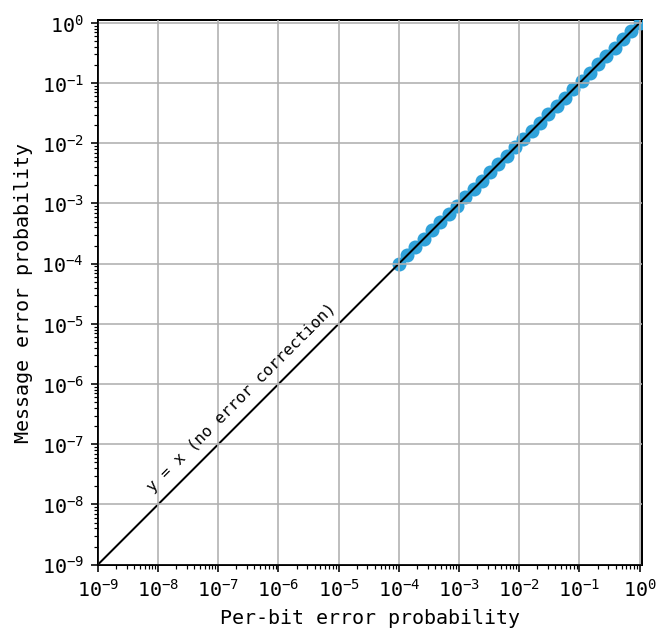
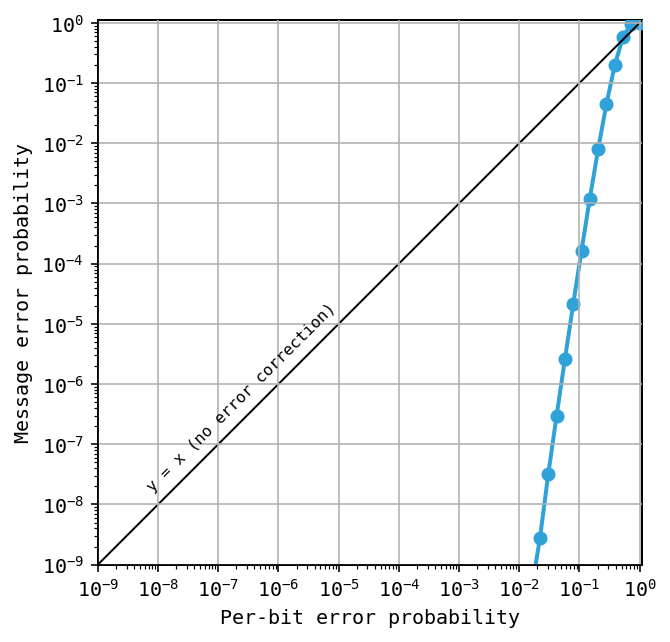
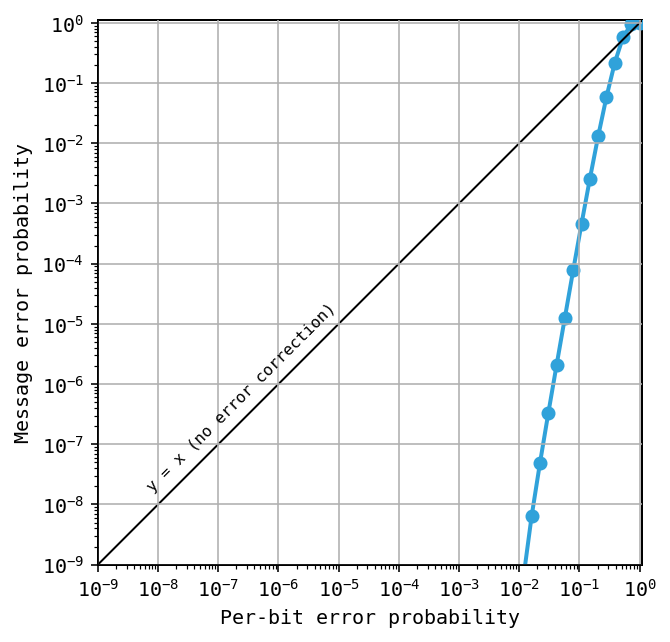
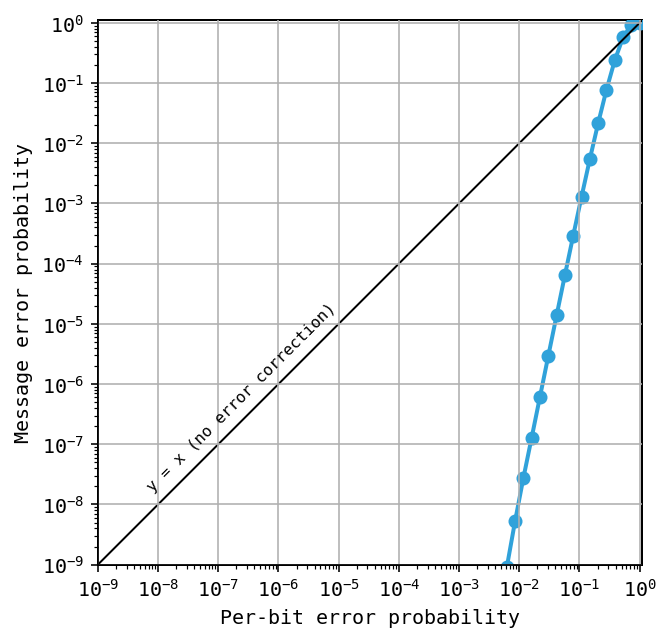
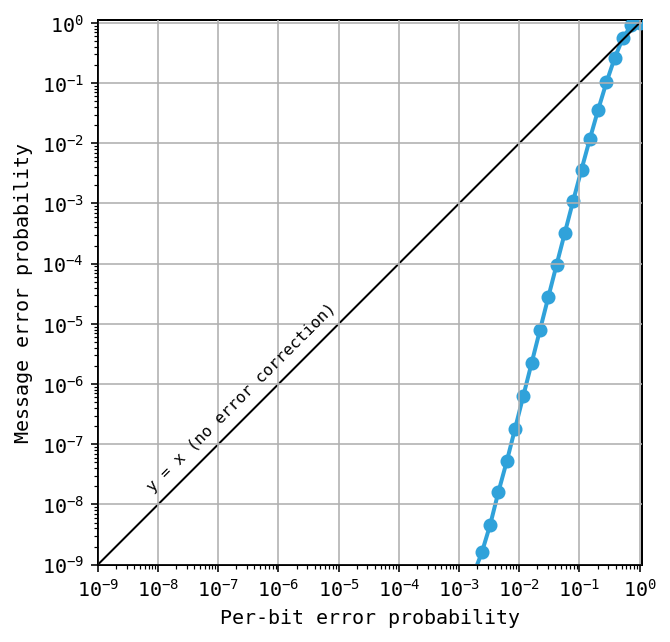
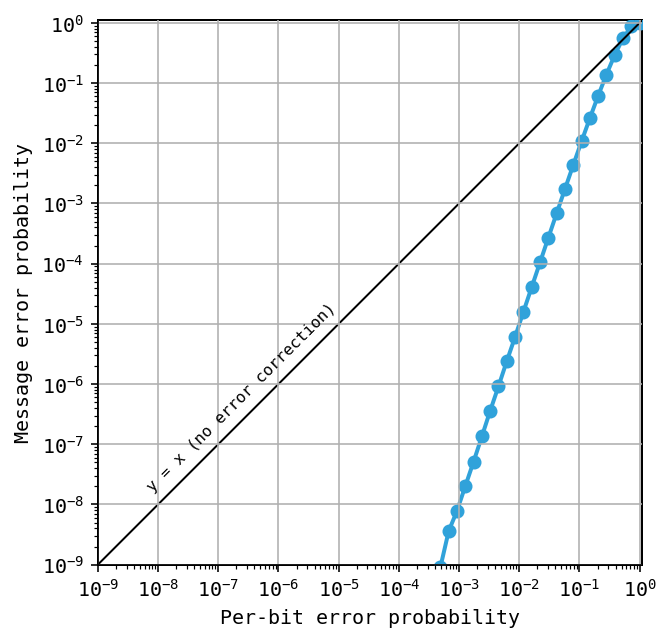
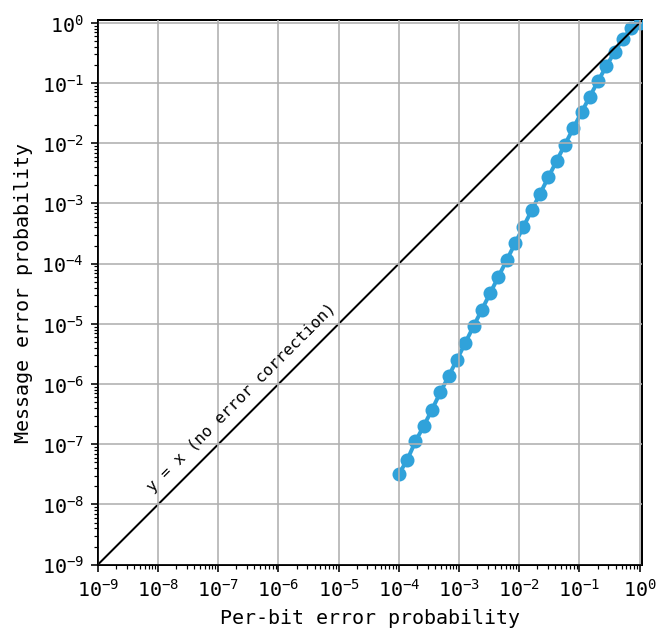
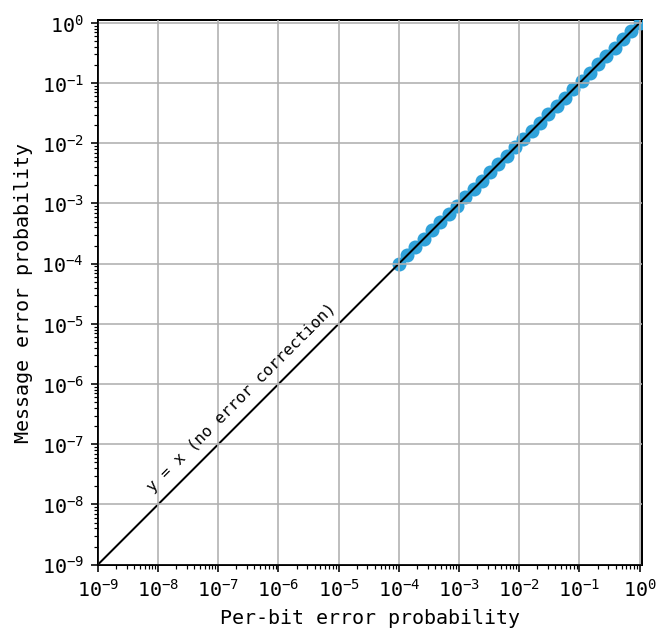

In [6]:
plot_and_slider

```{raw} html
    </div>
</div>
```

## Contents

### __Developing intuition for quantum error correction__
<ul>
  <li>Motivation for quantum error correction</li>
  <li><a href="classical-intuition.html">Lessons from classical error correction</a></li>
  <li>Majority vote vs parity checks</li>
</ul>

### __From classical to quantum repetition codes__
<ul>
  <li><a href="correctable-errors.html">Correctable errors</a></li>
  <li><a href="bit-flip-repetition-codes.html">Building the bit-flip quantum repetition code from scratch</a></li>
  <li><a href="phase-flip-repetition-codes.html">Retooling the bit-flip quantum repetition code to handle phase errors</a></li>
  <li><a href="shor-code.html">Combining bit-flip and phase-flip repetition codes: Shor's 9-qubit code</a></li>
</ul>

### __From repetition codes to surface codes__
<ul>
  <li>Introduction to surface codes</li>
    <li>Layout of unrotated surface code with stabilizers</li>
    <li>Syndrome extraction cycle with noise and logical operators</li>
    <li>Overview of the QEC cycle and introduction to Stim</li>
</ul>

### __Decoding surface codes__
<ul>
  <li>Introduction to minimum weight perfect matching</li>
  <li>Threshold theorem</li>
  <li>Simulating surface code in stim</li>
</ul>